In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

### Load Data From CSV File  

In [6]:
df = pd.read_csv('F://loan_train (1).csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [7]:
df.shape

(346, 10)

### Convert to date time object 

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [9]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: f:\Users\dell\anaconda3

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         165 KB  anaconda
    certifi-2019.11.28         |           py37_0         157 KB  anaconda
    conda-4.8.4                |           py37_0         3.1 MB  anaconda
    openssl-1.1.1d             |       he774522_4         5.1 MB  anaconda
    seaborn-0.10.0             |             py_0         161 KB  anaconda
    ------------------------------------------------------------
                                           Total:         8.6 MB

The following packages will be SUPERSEDED by a higher-priori


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-32::anaconda==2020.02=py37_0


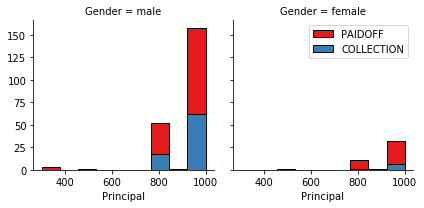

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

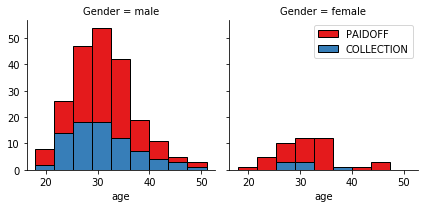

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Lets look at the day of the week people get the loan 

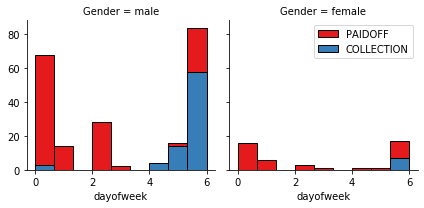

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

We will be using following modeling techniques:
- K Nearest Neighbor(KNN)
- Decision Tree
- Random Forest 
- Support Vector Machine
- Logistic Regression



# K Nearest Neighbor(KNN)
## Let's find the most approriate value for n_neighbors to use here


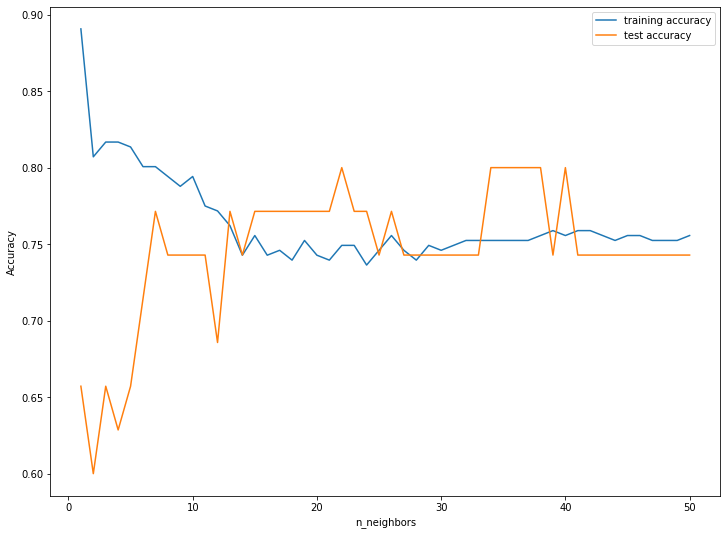

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=508,
    stratify=y)
############################################################################
# KNN - using KNearest Neighbors to build a predictive model
# Running the neighbor optimization code with a small adjustment for classification
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 51)
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(12, 9))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [23]:
# Looking for the highest test accuracy
#print(test_accuracy)

# Printing highest test accuracy
print(test_accuracy.index(max(test_accuracy)) + 1)

# It looks like 22 neighbors is the most accurate
knn_clf = KNeighborsClassifier(n_neighbors=22)

22


In [25]:
# Fitting the model based on the training data
knn_clf_fit = knn_clf.fit(X_train, y_train)
knn_clf_fit = knn_clf.fit(X_train, y_train)

# Let's compare the testing score to the training score.
print('Training Score', knn_clf_fit.score(X_train, y_train).round(4))
print('Testing Score:', knn_clf_fit.score(X_test, y_test).round(4))

Training Score 0.7492
Testing Score: 0.8


In [26]:
# Generating Predictions based on the optimal KNN model
knn_clf_pred = knn_clf_fit.predict(X_test)
#Actual predictions
model_predictions_df = pd.DataFrame({'Actual': y_test,
                                     'Predicted': knn_clf_pred})
model_predictions_df.head(20)

,Actual,Predicted
0,COLLECTION,PAIDOFF
1,COLLECTION,COLLECTION
2,PAIDOFF,PAIDOFF
3,PAIDOFF,PAIDOFF
4,PAIDOFF,PAIDOFF
5,COLLECTION,PAIDOFF
6,COLLECTION,COLLECTION
7,PAIDOFF,PAIDOFF
8,PAIDOFF,PAIDOFF
9,COLLECTION,PAIDOFF


# Decision Tree

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import numpy as np
# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.

y = pd.DataFrame(y)
y = y[0].apply(lambda x : 1 if 'paidoff' == x.lower() else 0)
y = np.array(y)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size =0.25)

for x in [5,25,50,100,500]:
    model = DecisionTreeClassifier(max_leaf_nodes=x, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    print("score for max_leaf_node {0} is {1}".format(x,accuracy_score(preds_val,val_y)))

score for max_leaf_node 5 is 0.7011494252873564
score for max_leaf_node 25 is 0.7011494252873564
score for max_leaf_node 50 is 0.6896551724137931
score for max_leaf_node 100 is 0.6781609195402298
score for max_leaf_node 500 is 0.6781609195402298


In [27]:
# Generating Predictions based on the optimal Binary Tree model
model = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
#Actual predictions
model_predictions_df = pd.DataFrame({'Actual': val_y,
                                     'Predicted': preds_val})
model_predictions_df.head(20)

,Actual,Predicted
0,0,0
1,1,1
2,0,1
3,1,1
4,1,0
5,1,1
6,1,1
7,1,0
8,1,1
9,1,0


<h1>Random Forest</h1>

In [28]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size =0.25)

for x in [5,25,50,100,500]:
    model = RandomForestClassifier(n_estimators=x, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    print("score for n_estomators {0} is {1}".format(x,accuracy_score(preds_val,val_y)))

score for n_estomators 5 is 0.7126436781609196
score for n_estomators 25 is 0.6896551724137931
score for n_estomators 50 is 0.7126436781609196
score for n_estomators 100 is 0.7011494252873564
score for n_estomators 500 is 0.7011494252873564


In [29]:
# Generating Predictions based on the optimal KNN model
model = RandomForestClassifier(n_estimators=5, random_state=1)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)
#Actual predictions
model_predictions_df = pd.DataFrame({'Actual': val_y,
                                     'Predicted': preds_val})
model_predictions_df.head(20)

,Actual,Predicted
0,0,1
1,1,1
2,0,0
3,1,0
4,1,1
5,1,1
6,1,1
7,1,0
8,1,1
9,1,0


# Support Vector Machine

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.7428571428571429


f:\Users\dell\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
#Actual predictions
model_predictions_df = pd.DataFrame({'Actual': y_test,
                                     'Predicted': y_pred})
model_predictions_df.head(20)

,Actual,Predicted
0,0,1
1,0,1
2,1,1
3,1,1
4,0,1
5,1,0
6,1,1
7,1,1
8,1,1
9,1,1


# Logistic Regression

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)
print(accuracy_score(y_pred,y_test))


0.8160919540229885


f:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
#Actual predictions
model_predictions_df = pd.DataFrame({'Actual': y_test,
                                     'Predicted': y_pred})
model_predictions_df.head(20)

,Actual,Predicted
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


# Model Evaluation using Test set

In [47]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

### Load Test set for evaluation 

In [51]:
#Preprocessing Steps
test_df = pd.read_csv('F://loan_test (1).csv')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_test = test_Feature
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
y_test = test_df['loan_status'].values
y_test = pd.DataFrame(y_test)
y_test = y_test[0].apply(lambda x : 1 if 'paidoff' == x.lower() else 0)
y_test = np.array(y_test)

In [54]:
#Fitting models and generating predictions
knn_clf = KNeighborsClassifier(n_neighbors=22)
knn_clf_fit = knn_clf.fit(X, y)
knn_clf_pred = knn_clf_fit.predict(X_test)
ja_knn = jaccard_score(y_test, knn_clf_pred)
f1_knn = f1_score(y_test, knn_clf_pred, average='weighted')
log_knn = log_loss(y_test, knn_clf_pred)

In [65]:
bin_model = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
bin_model.fit(X, y)
preds_val_bin = bin_model.predict(X_test)
ja_bin = jaccard_score(y_test, preds_val_bin)
f1_bin = f1_score(y_test, preds_val_bin, average='weighted')
log_bin = log_loss(y_test, preds_val_bin)

ran_model = RandomForestClassifier(n_estimators=5, random_state=1)
ran_model.fit(X,y)
preds_val_ran = ran_model.predict(X_test)
ja_ran = jaccard_score(y_test, preds_val_ran)
f1_ran = f1_score(y_test, preds_val_ran, average='weighted')
log_ran = log_loss(y_test, preds_val_ran)

svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X, y)
y_pred_sv = svclassifier.predict(X_test)
ja_sv = jaccard_score(y_test, y_pred_sv)
f1_sv = f1_score(y_test, y_pred_sv, average='weighted')
log_sv = log_loss(y_test, y_pred_sv)

logistic = LogisticRegression()
logistic.fit(X, y)
y_pred_log = logisticRegr.predict(X_test)
ja_log = jaccard_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log, average='weighted')
log_log = log_loss(y_test, y_pred_log)

f:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [86]:
#Let's store our results in a dataframe
df_result = []
Algorithim = ['KNN','Decision Tree','Random Forest','SVM','LogisticRegression']
Jaccard = [ja_knn, ja_bin, ja_ran, ja_sv, ja_log]
F1_score = [f1_knn, f1_bin, f1_ran, f1_sv, f1_log]
LogLoss = [log_knn, log_bin, log_ran, log_sv, log_log]

df_result = pd.DataFrame({"Algorithim":Algorithim, 
                    "Jaccard":Jaccard,
                          "F1_score":F1_score,
                         "LogLoss":LogLoss})
df_result

,Algorithim,Jaccard,F1_score,LogLoss
0,KNN,0.745098,0.714414,8.315053
1,Decision Tree,0.764706,0.728395,7.675447
2,Random Forest,0.612245,0.651988,12.152666
3,SVM,0.679245,0.626541,10.873511
4,LogisticRegression,0.754717,0.671764,8.315083
